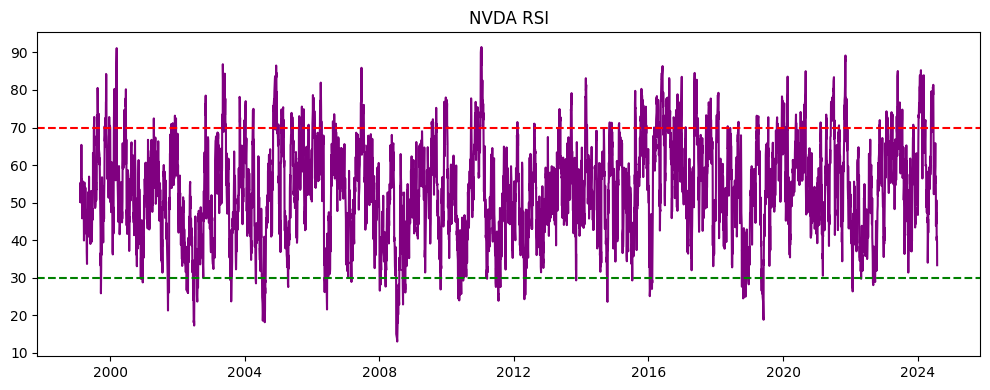

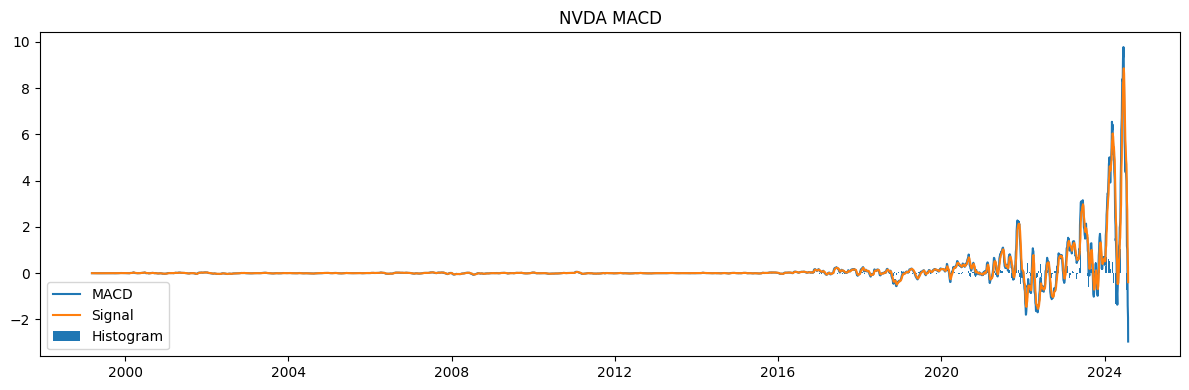

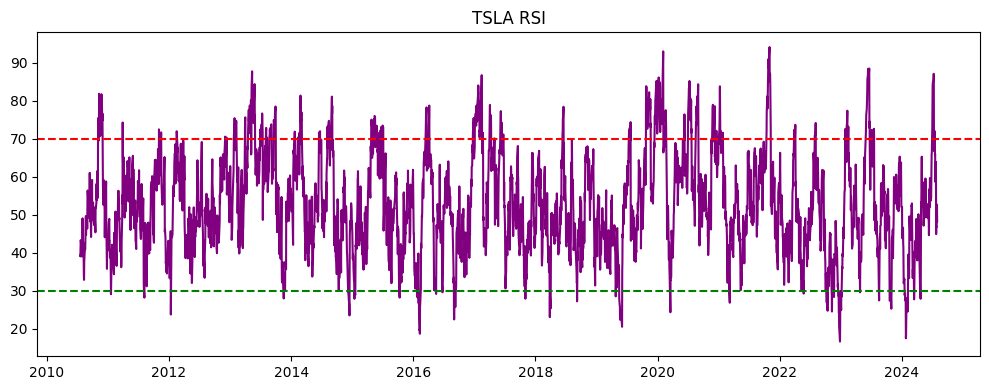

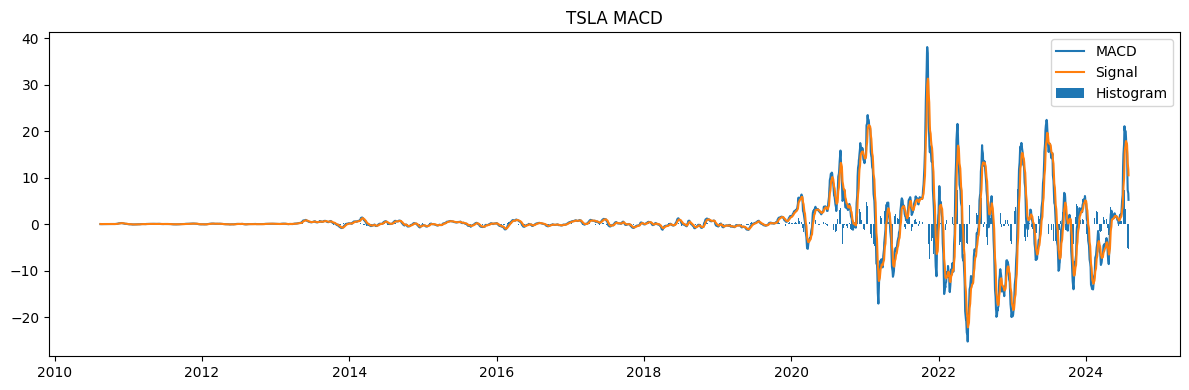

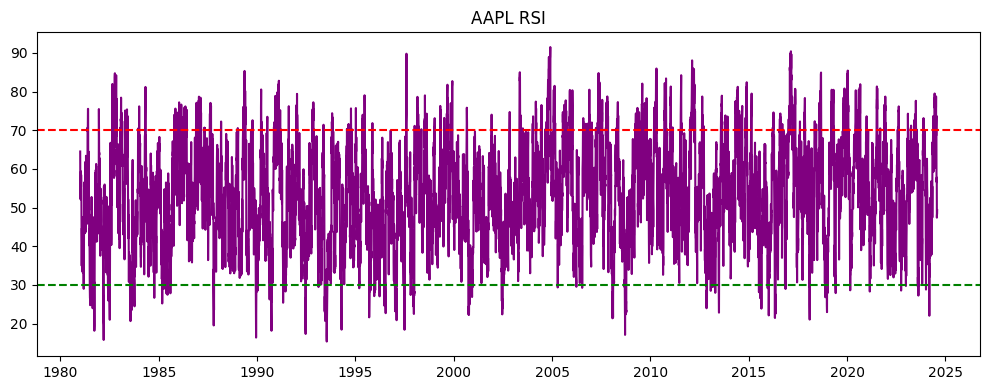

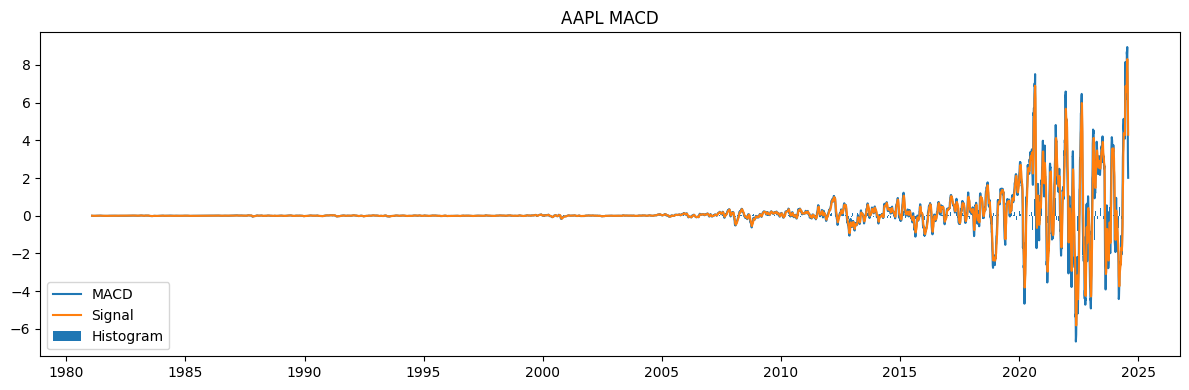

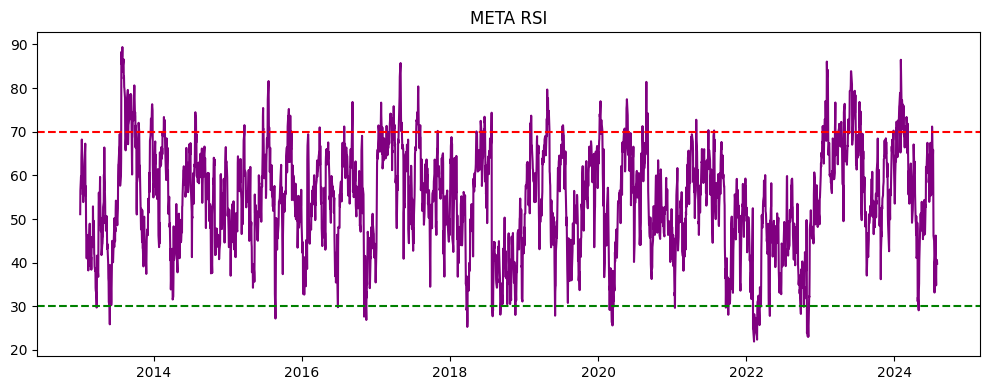

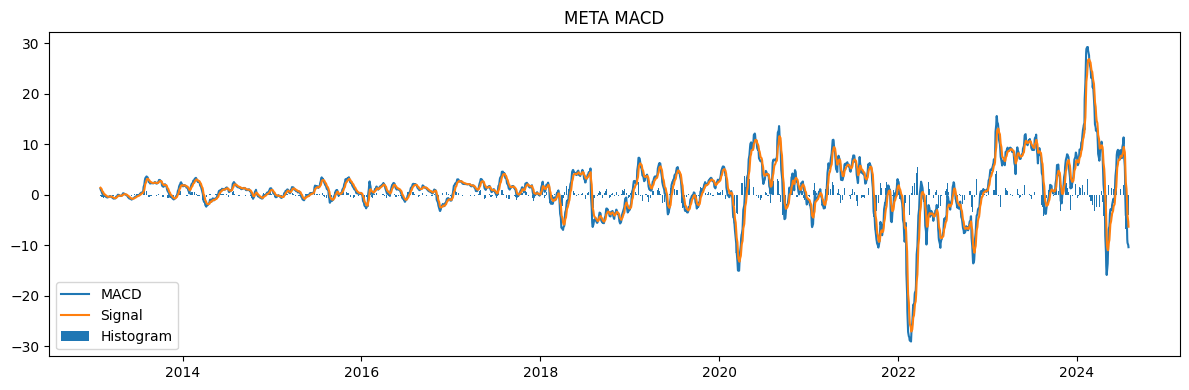

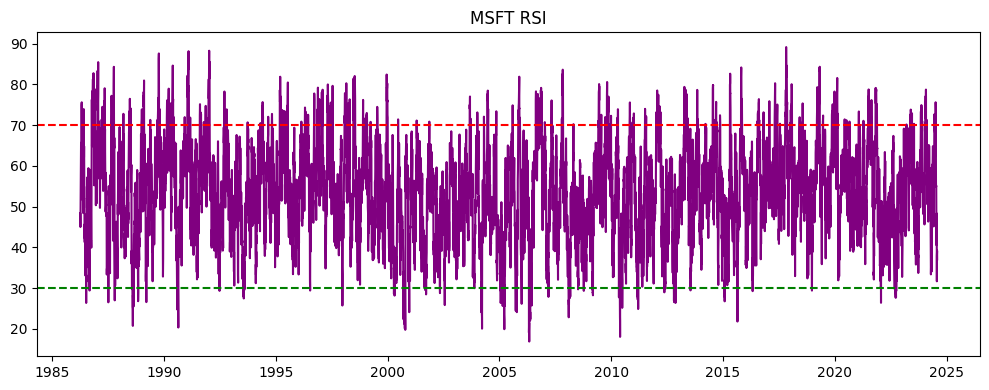

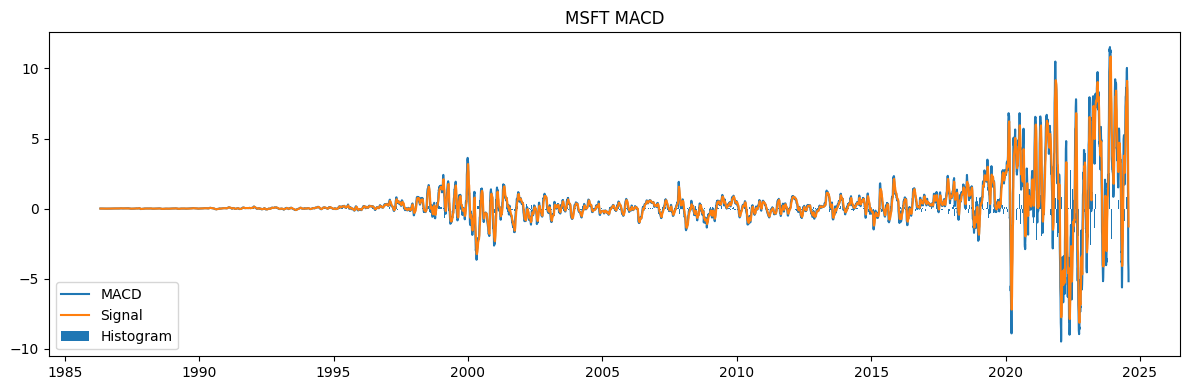

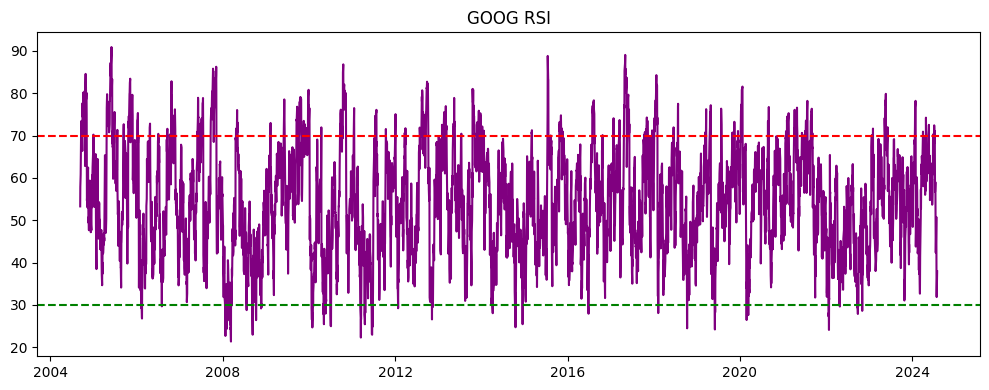

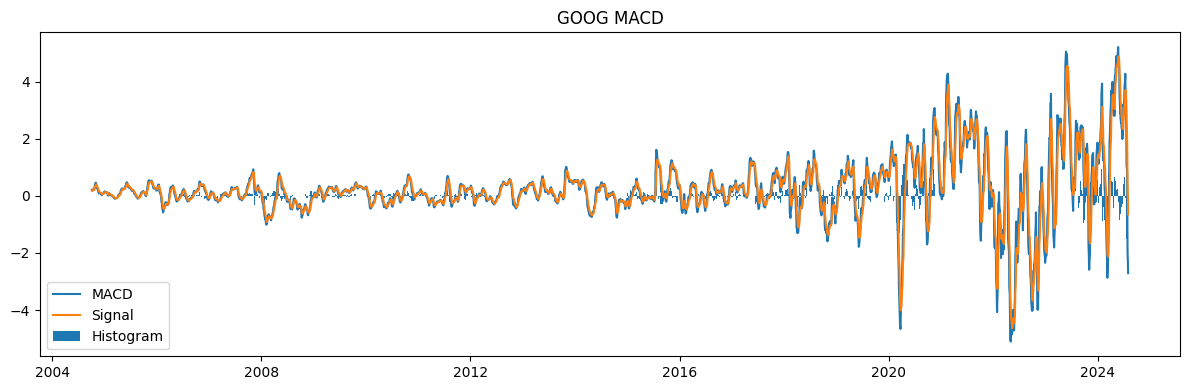

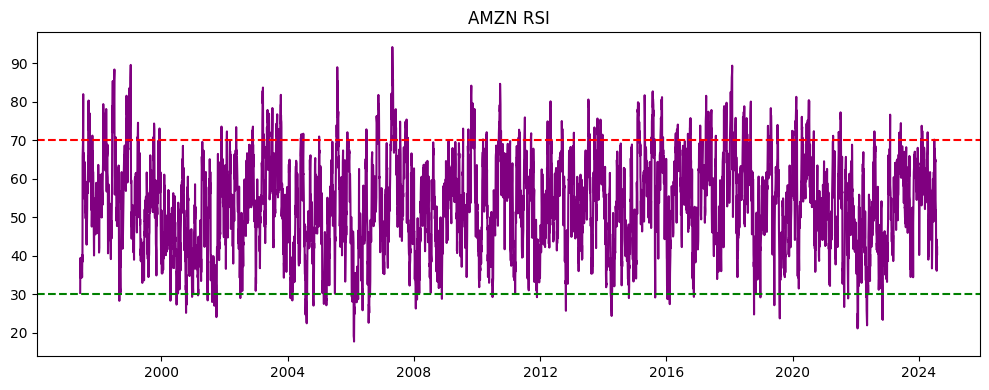

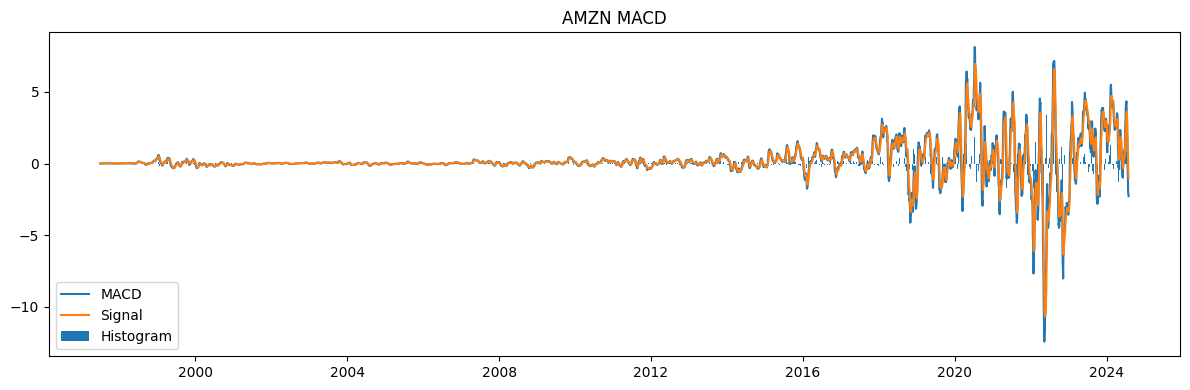

Task 2 complete: Indicators calculated and charts saved.

📊 TSLA Sentiment vs Daily Return
Pearson Correlation: 0.0277
P-value: 0.1909


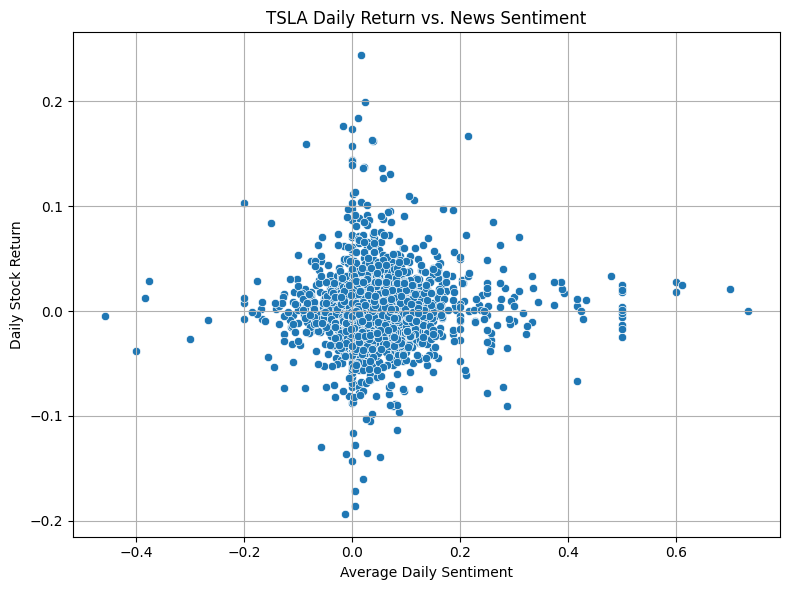


📊 NVDA Sentiment vs Daily Return
Pearson Correlation: 0.0093
P-value: 0.6623


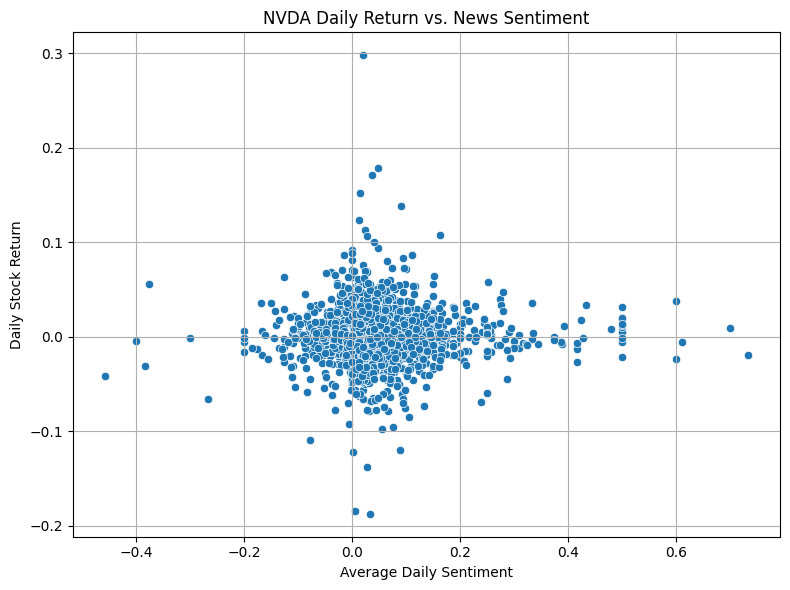


📊 AAPL Sentiment vs Daily Return
Pearson Correlation: -0.002
P-value: 0.9236


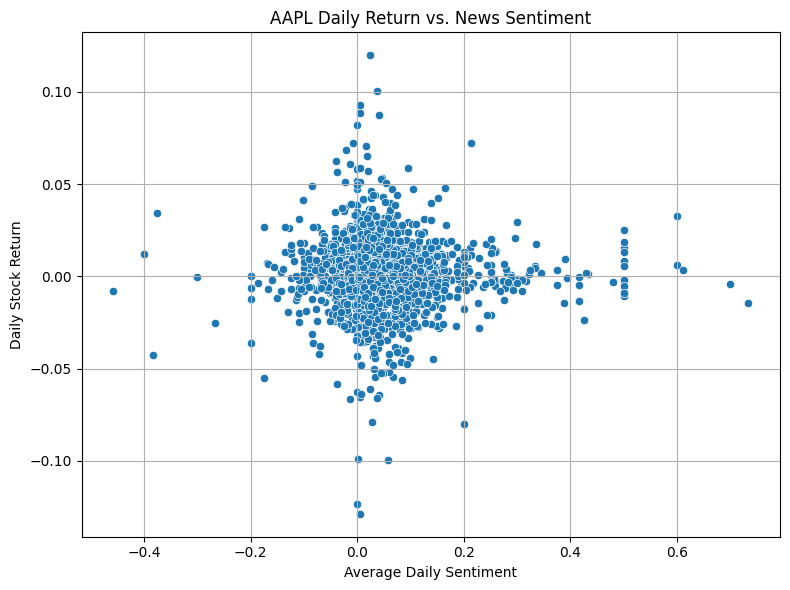


📊 META Sentiment vs Daily Return
Pearson Correlation: -0.0061
P-value: 0.7943


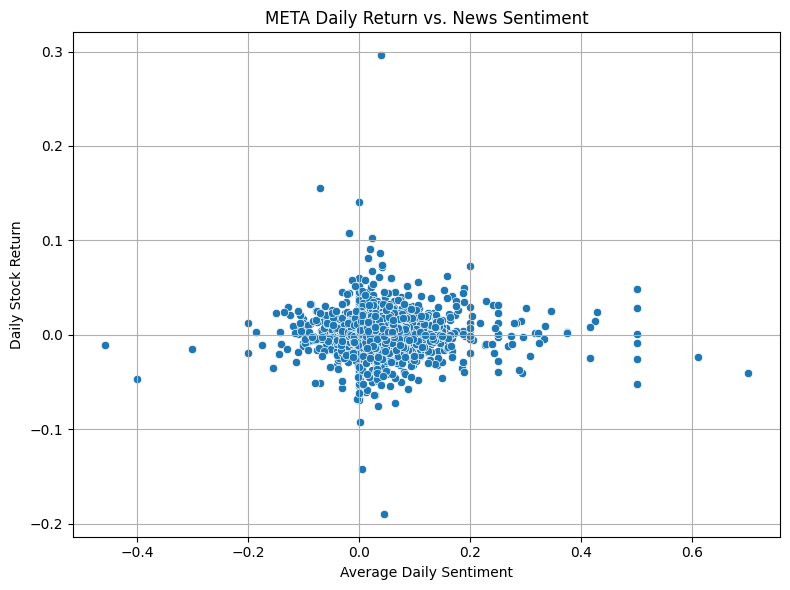


📊 MSFT Sentiment vs Daily Return
Pearson Correlation: -0.0128
P-value: 0.5449


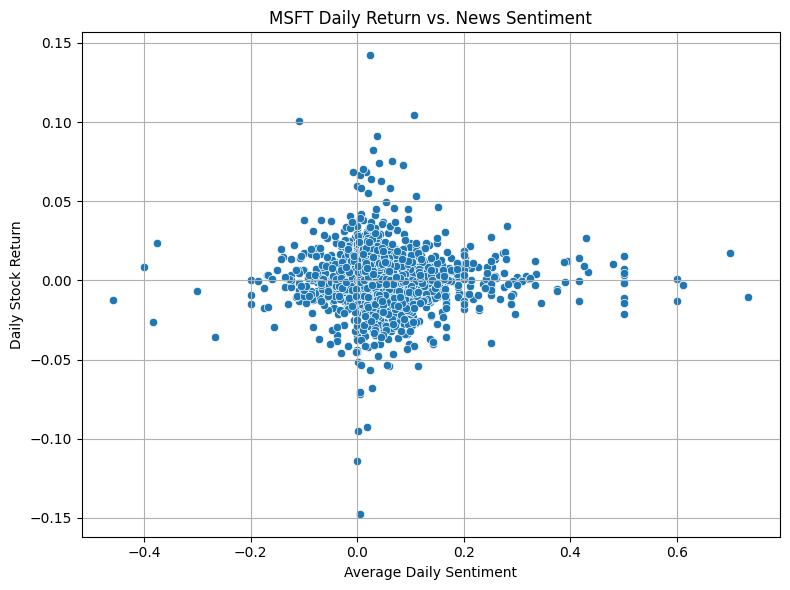


📊 GOOG Sentiment vs Daily Return
Pearson Correlation: 0.0143
P-value: 0.5007


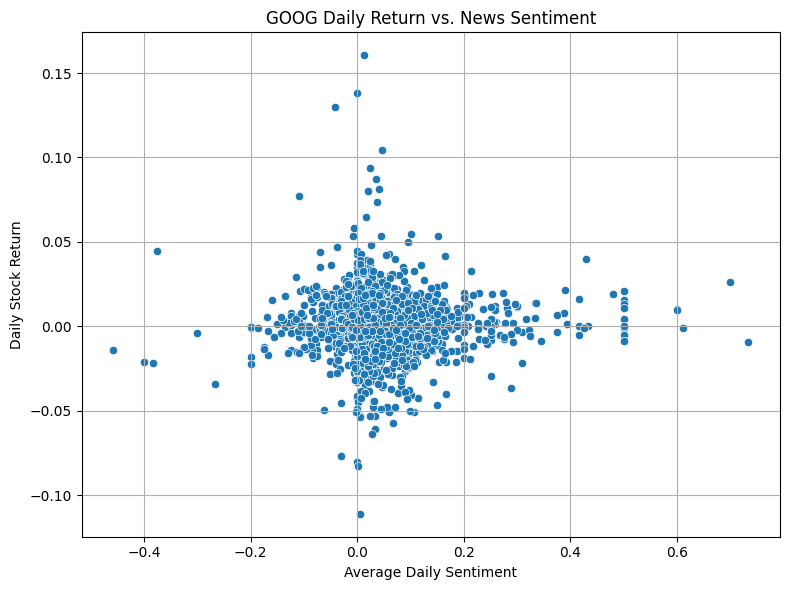


📊 AMZN Sentiment vs Daily Return
Pearson Correlation: -0.0194
P-value: 0.3592


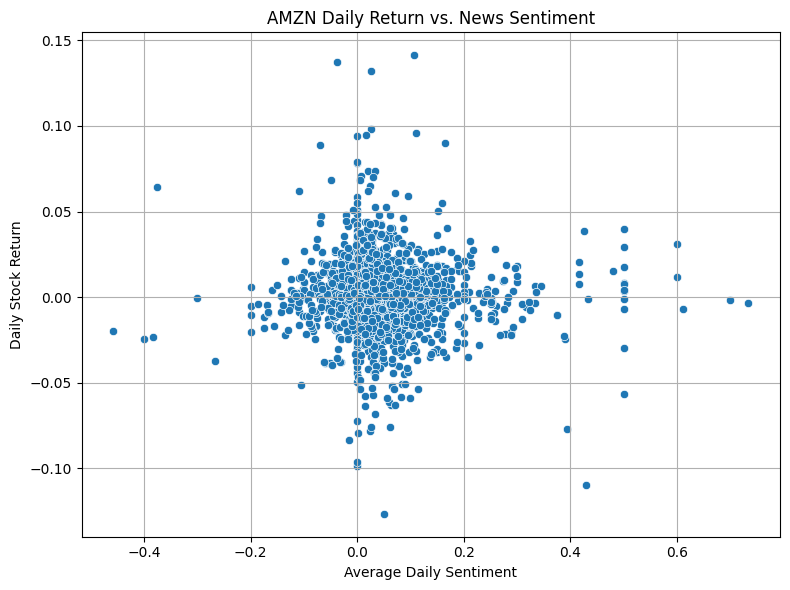


✅ Task 3 complete: Sentiment correlations calculated and plots saved.


In [3]:
# Task 2 - Technical Indicator Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import datetime as dt
import re
import talib


# Load stock price data
nvda_df = pd.read_csv("../data/NVDA_historical_data.csv")
tsla_df = pd.read_csv("../data/TSLA_historical_data.csv")
aapl_df = pd.read_csv("../data/AAPL_historical_data.csv")
meta_df = pd.read_csv("../data/META_historical_data.csv")
msft_df = pd.read_csv("../data/MSFT_historical_data.csv")
goog_df = pd.read_csv("../data/GOOG_historical_data.csv")
amzn_df = pd.read_csv("../data/AMZN_historical_data.csv")

stock_data = {
    'NVDA': nvda_df,
    'TSLA': tsla_df,
    'AAPL': aapl_df,
    'META': meta_df,
    'MSFT': msft_df,
    'GOOG': goog_df,
    'AMZN': amzn_df
}

# Clean and prepare data
for name, df in stock_data.items():
    df.columns = df.columns.str.strip().str.lower()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate technical indicators
    df['SMA_20'] = talib.SMA(df['close'], timeperiod=20)
    df['EMA_20'] = talib.EMA(df['close'], timeperiod=20)
    df['RSI'] = talib.RSI(df['close'], timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_signal'] = macdsignal
    df['MACD_hist'] = macdhist

    # Plot close + SMA + EMA
    plt.figure(figsize=(12,6))
    plt.plot(df['date'], df['close'], label='Close')
    plt.plot(df['date'], df['SMA_20'], label='SMA 20')
    plt.plot(df['date'], df['EMA_20'], label='EMA 20')
    plt.title(f'{name} Price with SMA & EMA')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name.lower()}_sma_ema.png")
    plt.close()
    
    # Plot RSI
    plt.figure(figsize=(10,4))
    plt.plot(df['date'], df['RSI'], color='purple')
    plt.axhline(70, color='red', linestyle='--')
    plt.axhline(30, color='green', linestyle='--')
    plt.title(f'{name} RSI')
    plt.tight_layout()
    plt.savefig(f"{name.lower()}_rsi.png")
    plt.show() 
    plt.close()

    # Plot MACD
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df['MACD'], label='MACD')
    plt.plot(df['date'], df['MACD_signal'], label='Signal')
    plt.bar(df['date'], df['MACD_hist'], label='Histogram')
    plt.title(f'{name} MACD')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name.lower()}_macd.png")
    plt.show() 
    plt.close()

    # Save processed data
    df.to_csv(f"../data/{name.lower()}_indicators.csv", index=False)

print("Task 2 complete: Indicators calculated and charts saved.")

# Task 3: Sentiment Correlation with Stock Movement

import nltk
from textblob import TextBlob
from scipy.stats import pearsonr

# Load cleaned news data
news_df = pd.read_csv("../data/cleaned_news_data.csv")
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

# Sentiment analysis using TextBlob
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Average daily sentiment
daily_sentiment = news_df.groupby(news_df['date'].dt.date)['sentiment'].mean().reset_index()
daily_sentiment.columns = ['date', 'avg_sentiment']
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# List of stock files and names
stocks = {
    'TSLA': "../data/tsla_indicators.csv",
    'NVDA': "../data/nvda_indicators.csv",
    'AAPL': "../data/AAPL_historical_data.csv",
    'META': "../data/META_historical_data.csv",
    'MSFT': "../data/MSFT_historical_data.csv",
    'GOOG': "../data/GOOG_historical_data.csv",
    'AMZN': "../data/AMZN_historical_data.csv"
}

# Process each stock
for ticker, filepath in stocks.items():
    try:
        stock_df = pd.read_csv(filepath)
        stock_df.columns = stock_df.columns.str.lower()
        stock_df['date'] = pd.to_datetime(stock_df['date'], errors='coerce')
        stock_df = stock_df.sort_values('date')

        stock_df['close'] = pd.to_numeric(stock_df['close'], errors='coerce')
        stock_df['daily_return'] = stock_df['close'].pct_change()

        merged_df = pd.merge(stock_df, daily_sentiment, on='date', how='inner')
        merged_df_clean = merged_df[['avg_sentiment', 'daily_return']].dropna()

        if not merged_df_clean.empty:
            corr, pval = pearsonr(merged_df_clean['avg_sentiment'], merged_df_clean['daily_return'])

            print(f"\n📊 {ticker} Sentiment vs Daily Return")
            print(f"Pearson Correlation: {round(corr, 4)}")
            print(f"P-value: {round(pval, 4)}")

            # Plot
            plt.figure(figsize=(8,6))
            sns.scatterplot(x='avg_sentiment', y='daily_return', data=merged_df_clean)
            plt.title(f'{ticker} Daily Return vs. News Sentiment')
            plt.xlabel('Average Daily Sentiment')
            plt.ylabel('Daily Stock Return')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f"{ticker.lower()}_sentiment_correlation.png")
            plt.show() 
            plt.close()
        else:
            print(f"⚠️ Not enough data to calculate correlation for {ticker}")

    except Exception as e:
        print(f"\n⚠️ Could not process {ticker}: {str(e)}")

print("\n✅ Task 3 complete: Sentiment correlations calculated and plots saved.")
